# Traffic Classification using k Nearest Neighbor

# Background

## Motivation

I am currently working on feature extraction and identification using simple k nearest neighbor clustering algorithms over a data set.

### Preliminary Information

We're using a dataset that has been pre-captured, cleaned and labeled by an ongoing effort found here : https://stratosphereips.org/category/dataset.html

They're currently working to on a machine learning effort for Malware classification, much like the example we're showing here.

The dataset currently contains typical Netflow capture information, including time stamps, durations of the flows, Src/DstIP's, Src/Dst Port, and other flow related information. The key to the provided dataset was that it is labeled. We can then use these labels to start to train a model to identify and classify unlabeled flows as any of the labels provided in the dataset.

In [1]:
# Create Class for formatting of the TimeStamp field contained within the netflow captures

setClass("myPosixCt")
setAs("character", "myPosixCt", function(from) as.POSIXct(from, format = "%Y/%m/%d %H:%M:%OS"))
options(set.seconds="6")

# Read .binetflow file into dataframe

flowdata_csv <- read.csv("capture20110810.binetflow", colClasses = c("myPosixCt", "numeric", "factor", "factor","factor","factor","factor","factor","factor","factor","factor","numeric", "numeric", "numeric", "factor"), strip.white = TRUE, sep = ',')

In [2]:
library(caret)
library(pander)
library(doMC)
library(dplyr)


# Register CPU core count
registerDoMC(cores=23)

# Utility function for use with % frequency tables
frqtab <- function(x, caption) {
    round(100*prop.table(table(x)), 3)
}

# Utility function to round values in a list
# but only if they are numeric

round_numeric <- function(lst, decimals=2) {
    lappy(lst, function(x){
        if (is.numeric(x)) {
            x <- round(x, decimals)
        }
        return(x)
    })
}

# Utility function for model comparison

summod <- function(cm, fit) {
    summ <- list(k = fit$finalModel$k,
                metric = fit$metric,
                value = fit$results[fit$resultes$k == fit$finalModel$k, fit$metric],
                TN = cm$table[1,1], # True negatives
                TP = cm$table[2,2], # True positives
                FN = cm$table[1,2], # False negatives
                FP = cm$table[2,1], # False positives
                acc = cm$overall["Accuracy"], 
                sens = cm$byClass["Sensitivity"],
                spec = cm$byClass["Specificity"],
                PPV = cm$byClass["Positive Predicted Value"],
                NPV = cm$byClass["Negative Prediced Value"])
    round_numeric(summ)
}

# Utility function to normalize the data

normalize <- function(x){
    num <- x - min(x)
    denom <- max(x) - min(x)
    return (num/denom)
}

# Hours Function
hours <- function(h) {
    x <- h * 3600
    return(x)
}

# Minutes Function
mins <- function(m) {
    x <- m * 60
    return(x)
}

# Seconds function
secs <- function(s) {
    x <- s
    return(x)
}

Loading required package: lattice
Loading required package: ggplot2
Loading required package: foreach
Loading required package: iterators
Loading required package: parallel

Attaching package: ‘dplyr’

The following objects are masked from ‘package:stats’:

    filter, lag

The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union



In [3]:
# Subset and normalize data

flowdata_csv$Label <- as.character(flowdata_csv$Label)

flowdata_csv <- subset(flowdata_csv, flowdata_csv$StartTime[1] + hours(1) >= flowdata_csv$StartTime)

'data.frame':	549627 obs. of  15 variables:
 $ StartTime: POSIXct, format: "2011-08-10 09:46:59" "2011-08-10 09:47:00" ...
 $ Dur      : num  1.03 1.01 3.06 3.11 3.08 ...
 $ Proto    : Factor w/ 15 levels "arp","esp","icmp",..: 12 12 12 12 12 12 12 12 12 12 ...
 $ SrcAddr  : Factor w/ 542093 levels "::","0.0.0.0",..: 505956 505956 86275 86275 86275 86275 190291 300804 300804 103735 ...
 $ Sport    : Factor w/ 64753 levels "","0x0003","0x0004",..: 6376 6376 41594 41815 42499 42675 41846 4633 5428 35049 ...
 $ Dir      : Factor w/ 7 levels "<-","<->","<?",..: 5 5 5 5 5 5 5 5 5 5 ...
 $ DstAddr  : Factor w/ 119296 levels "00:0c:29:97:a3:eb",..: 21237 21237 77983 77983 77983 77983 21237 21237 21237 21171 ...
 $ Dport    : Factor w/ 73787 levels "","0x0001","0x0002",..: 70635 70635 71764 71764 71764 71764 70635 70635 70635 13007 ...
 $ State    : Factor w/ 231 levels "","A_","A_A",..: 191 191 192 192 192 192 191 191 191 218 ...
 $ sTos     : Factor w/ 6 levels "","0","1","192",..: 2 2 2 2 2

In [4]:
# Prune dataset to start with just continuous variables right now

#Define continuous vars, subset flowdata and save as CSV

contvars <- names(flowdata_csv) %in% c("StartTime", "Proto", "SrcAddr", "Sport", "Dir", "DstAddr", "Dport", "State", "sTos", "dTos")
flowdata_conts <- flowdata_csv[!contvars]

str(flowdata_conts)

# Write out to csv file for persistence

write.csv(flowdata_conts, file='flowdata_conts.csv')

str(flowdata_conts)

'data.frame':	549627 obs. of  5 variables:
 $ Dur     : num  1.03 1.01 3.06 3.11 3.08 ...
 $ TotPkts : num  4 4 3 3 3 3 4 4 4 5 ...
 $ TotBytes: num  276 276 182 182 182 182 244 252 252 352 ...
 $ SrcBytes: num  156 156 122 122 122 122 124 132 132 208 ...
 $ Label   : chr  "flow=Background-Established-cmpgw-CVUT" "flow=Background-Established-cmpgw-CVUT" "flow=Background-TCP-Attempt" "flow=Background-TCP-Attempt" ...
'data.frame':	549627 obs. of  5 variables:
 $ Dur     : num  1.03 1.01 3.06 3.11 3.08 ...
 $ TotPkts : num  4 4 3 3 3 3 4 4 4 5 ...
 $ TotBytes: num  276 276 182 182 182 182 244 252 252 352 ...
 $ SrcBytes: num  156 156 122 122 122 122 124 132 132 208 ...
 $ Label   : chr  "flow=Background-Established-cmpgw-CVUT" "flow=Background-Established-cmpgw-CVUT" "flow=Background-TCP-Attempt" "flow=Background-TCP-Attempt" ...


In [5]:
# Normalize the data

cont_vars <- c("Dur", "TotPkts", "TotBytes", "SrcBytes")

flowdata_conts <- flowdata_conts %>% mutate_each_(funs(normalize), vars = cont_vars)

# Clean flowdata_conts, totally hacky but dataframe transforms are crazy fast and scale well

flowdata_conts <- flowdata_conts[!(flowdata_conts$Dur == 0),]
flowdata_conts <- flowdata_conts[!(flowdata_conts$TotPkts == 0),]
flowdata_conts <- flowdata_conts[!(flowdata_conts$TotBytes == 0),]
flowdata_conts <- flowdata_conts[!(flowdata_conts$SrcBytes == 0),]

'data.frame':	516558 obs. of  5 variables:
 $ Dur     : num  0.000285 0.00028 0.000849 0.000864 0.000857 ...
 $ TotPkts : num  2.12e-06 2.12e-06 1.41e-06 1.41e-06 1.41e-06 ...
 $ TotBytes: num  1.70e-07 1.70e-07 9.63e-08 9.63e-08 9.63e-08 ...
 $ SrcBytes: num  6.28e-07 6.28e-07 4.91e-07 4.91e-07 4.91e-07 ...
 $ Label   : chr  "flow=Background-Established-cmpgw-CVUT" "flow=Background-Established-cmpgw-CVUT" "flow=Background-TCP-Attempt" "flow=Background-TCP-Attempt" ...


In [29]:
# Re-factor-fy variable

flowdata_conts$Label <- as.factor(flowdata_conts$Label)

# Set randomization seed

set.seed(1234)

# Break dataset into training and test sets
## split dataset randomly with a 67/33% distribution

ind <- sample(2, nrow(flowdata_conts), replace=TRUE, prob=c(0.67, 0.33))

flowdata_training <- flowdata_conts[ind==1,]
flowdata_test <- flowdata_conts[ind==2,]

#flowdata_training_classes <- flowdata_conts[ind==1,5]
#flowdata_test_classes <- flowdata_conts[ind==2,5]

 Factor w/ 43 levels "flow=Background",..: 4 4 23 23 23 4 4 4 24 4 ...
 Factor w/ 43 levels "flow=Background",..: 23 4 4 4 24 4 24 24 24 4 ...


In [30]:
# Display label distribution in datasets

ft_orig <- frqtab(flowdata_conts$Label)
label_freq <- pander(ft_orig, style="rmarkdown", caption="Original Label Frequency (%)")

ft_train <- frqtab(flowdata_training$Label)
ft_test <- frqtab(flowdata_test$Label)
ftcmp_df <- as.data.frame(cbind(ft_orig, ft_train, ft_test))
colnames(ftcmp_df) <- c("Original", "Training Set", "Test Set")
pander(ftcmp_df, style="rmarkdown",
              caption="Comparison of Label frequencies ( in %)")



|  flow=Background  |  flow=Background-ajax.google  |
|:-----------------:|:-----------------------------:|
|       0.782       |             0.035             |

Table: Original Label Frequency (%) (continued below)

 

|  flow=Background-Attempt-cmpgw-CVUT  |
|:------------------------------------:|
|                0.377                 |

Table: Table continues below

 

|  flow=Background-Established-cmpgw-CVUT  |
|:----------------------------------------:|
|                  3.829                   |

Table: Table continues below

 

|  flow=Background-google-analytics1  |  flow=Background-google-analytics10  |
|:-----------------------------------:|:------------------------------------:|
|                0.017                |                0.042                 |

Table: Table continues below

 

|  flow=Background-google-analytics11  |  flow=Background-google-analytics12  |
|:------------------------------------:|:------------------------------------:|
|                0.0

In [ ]:
set.seed(123)

# Create list for seed used with parallelization

seeds <- vector(mode = "list", length = 51)
for (i in 1:50) seeds[[i]] <- sample.int(1000, 22)

# Used for last model
    
seeds[[51]] <- sample.int(1000, 1)

# Define training parameters
    
ctrl <- trainControl(method="repeatedcv", repeats=3, seeds = seeds)

# Run training! LET THE COMPUTER OVERLORD LEARN
    
system.time(
knnFit1 <- train(Label ~., flowdata_training, method="knn",
                trControl = ctrl, tuneLength = 10, preProcess = c("scale", "center", "pca"))
)

# Output stats TODO : convert to markdown for web / slide view

knnFit1

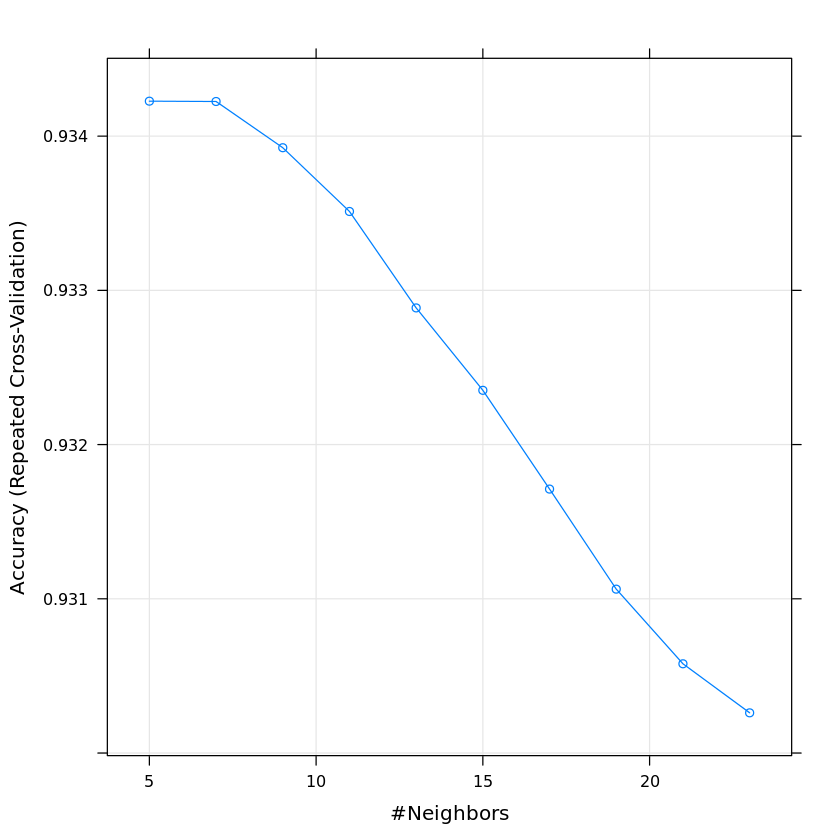

In [9]:
plot(knnFit1)

In [10]:
# Run prediction over test dataset
system.time(
knnPredict1 <- predict(knnFit1, newdata = flowdata_test)
)

   user  system elapsed 
300.392   0.224 300.454 

In [20]:
# Calculate confusion matric for prediction accuracy
cmat1 <- confusionMatrix(knnPredict1, flowdata_test)

ERROR: Error in sort.list(y): 'x' must be atomic for 'sort.list'
Have you called 'sort' on a list?
